In [180]:
import kagglehub
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# Overview:

**Title**: Predicting video game sales based off genre and year

**Authors**: Taylor Beimel, Jose Garcia, Tyler Fregoso, Prince Sanchez

**Dataset**: Our dataset is the sale description of most popular video games. Link: https://www.kaggle.com/datasets/atharvaingle/video-games-dataset/data

**Goal**: We will create a model to predict game sales based on genre and year, and use genre, year, and Global Sales features as predictors.

# Data Loading:
- First, we'll download and load the video games dataset from Kaggle.

In [183]:
dataset_path = kagglehub.dataset_download("atharvaingle/video-games-dataset")

df = pd.read_csv(os.path.join(dataset_path, "Video Games Dataset.csv"))
df.head()

,Rank,Name,Platform,Year,Genre,Publisher,NorthAmerica_Sales,EurpeanUnion_Sales,Japan_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008,Racing,Nintendo,NaN,12.88,3.79,NaN,35.82
3,4,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.75,11.01,NaN,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


# Data Cleaning:
- We'll clean the dataset by removing rows with missing values in our key columns (Year, Genre, and Global_Sales).

In [185]:
df.drop(['Publisher', 'Platform'], axis=1)

,Rank,Name,Year,Genre,NorthAmerica_Sales,EurpeanUnion_Sales,Japan_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,2006,Sports,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,1985,Platform,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,2008,Racing,NaN,12.88,3.79,NaN,35.82
3,4,Wii Sports Resort,2009,Sports,15.75,11.01,NaN,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,1996,Role-Playing,11.27,8.89,10.22,1.00,31.37
...,...,...,...,...,...,...,...,...,...
194,220,FIFA 15,2014,Sports,0.57,3.14,0.04,1.07,4.82
195,221,Crash Team Racing,1999,Racing,2.57,1.57,0.44,0.21,4.79
196,222,FIFA 17,2016,Sports,0.28,3.75,0.06,0.69,4.77
197,223,Batman: Arkham City,2011,Action,2.99,1.31,0.04,0.41,4.76


In [186]:
df = df.dropna(subset=["Year", "Genre", "Global_Sales"])

In [187]:
df["Year"] = df["Year"].astype(int)
df.head()

,Rank,Name,Platform,Year,Genre,Publisher,NorthAmerica_Sales,EurpeanUnion_Sales,Japan_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008,Racing,Nintendo,NaN,12.88,3.79,NaN,35.82
3,4,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.75,11.01,NaN,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


# Data Aggregation:
- We'll aggregate the sales data by Year and Genre to understand overall trends.

In [189]:
genre_sales = (
    df.groupby(["Year", "Genre"])["Global_Sales"]
      .sum()
      .reset_index()  # Converts the Series to a DataFrame
      .sort_values(by="Year", ascending=False)
)
genre_sales.head()

,Year,Genre,Global_Sales
117,2016,Sports,4.77
116,2015,Sports,8.49
115,2015,Shooter,29.21
114,2015,Role-Playing,6.96
113,2014,Sports,11.41


# Data Visualization:
- We'll use a stem plot to visualize sales trends by genre over time, which is more appropriate for discrete data.

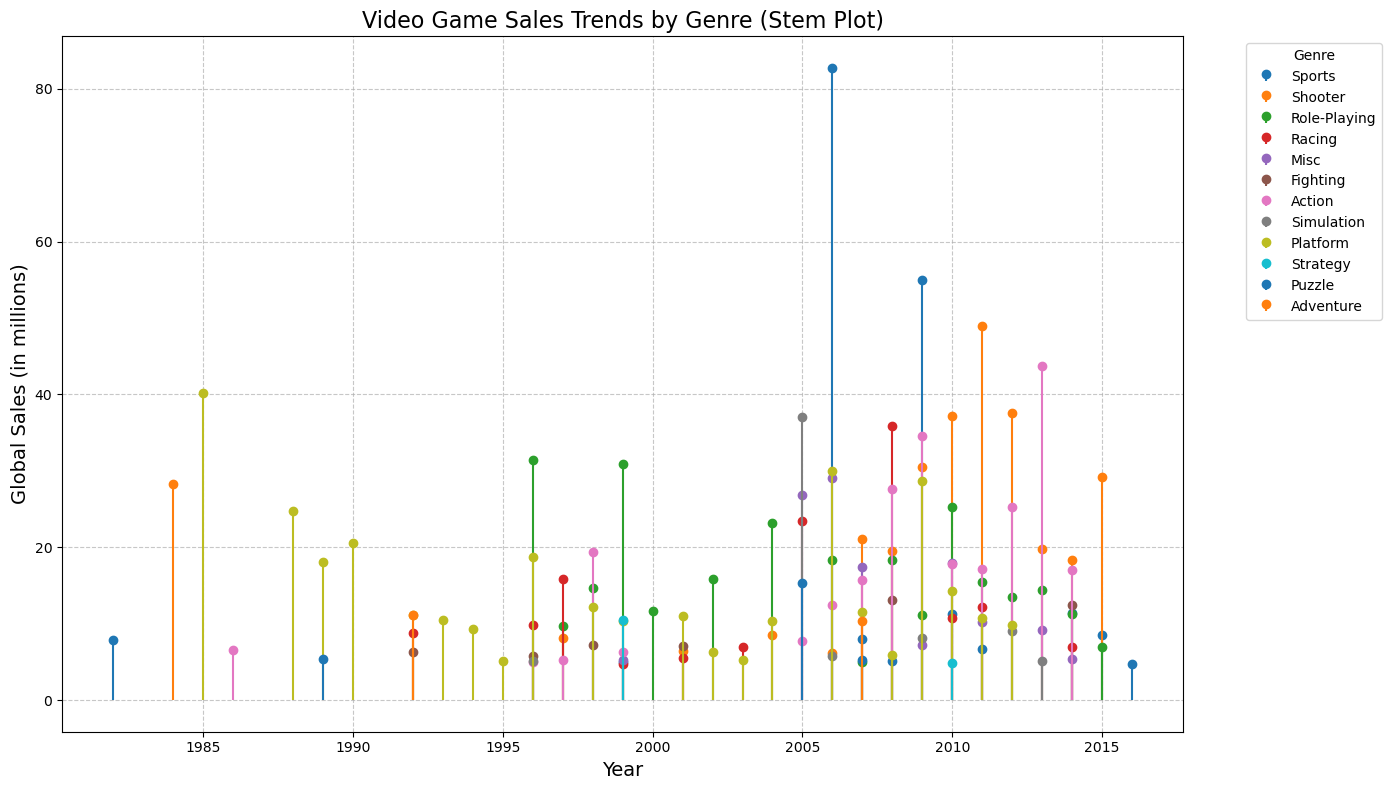

In [191]:
plt.figure(figsize=(14, 8))
genres = genre_sales["Genre"].unique()
colors = plt.cm.tab10(np.linspace(0, 1, len(genres)))

for i, genre in enumerate(genres):
    genre_data = genre_sales[genre_sales["Genre"] == genre]
    plt.stem(genre_data["Year"], genre_data["Global_Sales"], 
             linefmt=f'C{i}-', markerfmt=f'C{i}o', basefmt=' ', 
             label=genre)

plt.title("Video Game Sales Trends by Genre (Stem Plot)", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Global Sales (in millions)", fontsize=14)
plt.legend(title="Genre", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Data Transformation:
- We'll transform our aggregated data into a wide format where each column represents a genre and each row represents a year. This will be used for our predictive models.

In [193]:
genre_sales_wide = genre_sales.pivot(index="Year", columns="Genre", values="Global_Sales").fillna(0)
print(genre_sales_wide.head())

Genre  Action  Adventure  Fighting  Misc  Platform  Puzzle  Racing  \
Year                                                                 
1982     0.00        0.0       0.0   0.0      0.00    7.81     0.0   
1984     0.00        0.0       0.0   0.0      0.00    0.00     0.0   
1985     0.00        0.0       0.0   0.0     40.24    0.00     0.0   
1986     6.51        0.0       0.0   0.0      0.00    0.00     0.0   
1988     0.00        0.0       0.0   0.0     24.74    0.00     0.0   

Genre  Role-Playing  Shooter  Simulation  Sports  Strategy  
Year                                                        
1982            0.0     0.00         0.0     0.0       0.0  
1984            0.0    28.31         0.0     0.0       0.0  
1985            0.0     0.00         0.0     0.0       0.0  
1986            0.0     0.00         0.0     0.0       0.0  
1988            0.0     0.00         0.0     0.0       0.0  


# Data Splitting:
- We'll train our model with data until 2014 and then test it on 2015 data.

In [195]:
X = genre_sales_wide.index.values.reshape(-1, 1) 
y = genre_sales_wide 

X_train = X[X.flatten() <= 2014]
y_train = y.loc[y.index <= 2014]
X_test = X[X.flatten() == 2015]
y_test = y.loc[y.index == 2015]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((30, 1), (1, 1), (30, 12), (1, 12))

# Linear Regression Model:
- We'll train a Linear Regression model for each genre using the data up to 2014, and then test it on 2015 data.

In [197]:
models = {}
predictions = {}

for genre in y_train.columns:
    model = LinearRegression()
    model.fit(X_train, y_train[genre])
    models[genre] = model
    predictions[genre] = model.predict(X_test)
predictions  

{'Action': array([22.96206936]),
 'Adventure': array([0.73495971]),
 'Fighting': array([3.24659312]),
 'Misc': array([11.0940364]),
 'Platform': array([8.70676716]),
 'Puzzle': array([0.77805418]),
 'Racing': array([9.25478619]),
 'Role-Playing': array([18.16330365]),
 'Shooter': array([24.07199685]),
 'Simulation': array([5.51487966]),
 'Sports': array([16.09755054]),
 'Strategy': array([0.83006964])}

# Model Evaluation:
- We'll evaluate our models using Mean Absolute Error (MAE) for each genre.

In [199]:
errors = {}
for genre, pred in predictions.items():
    error = mean_absolute_error(y_test[genre], pred)
    errors[genre] = error
    print(f"{genre}: MAE = {error:.2f}")

Action: MAE = 22.96
Adventure: MAE = 0.73
Fighting: MAE = 3.25
Misc: MAE = 11.09
Platform: MAE = 8.71
Puzzle: MAE = 0.78
Racing: MAE = 9.25
Role-Playing: MAE = 11.20
Shooter: MAE = 5.14
Simulation: MAE = 5.51
Sports: MAE = 7.61
Strategy: MAE = 0.83


# Testing with Less Data:
- We'll also train models with less data (up to 2013) and test them on 2014-2015 data to see how the error increases.

In [201]:
X_train_2013 = X[X.flatten() <= 2013]
y_train_2013 = y.loc[y.index <= 2013]
X_test_2014_2015 = X[X.flatten() >= 2014]
y_test_2014_2015 = y.loc[y.index >= 2014]
models_2013 = {}
predictions_2013 = {}

for genre in y_train.columns:
    model = LinearRegression()
    model.fit(X_train_2013, y_train_2013[genre])
    models_2013[genre] = model
    predictions_2013[genre] = model.predict(X_test_2014_2015)

errors_2013 = {}
for genre, pred in predictions_2013.items():
    error = mean_absolute_error(y_test_2014_2015[genre], pred)
    errors_2013[genre] = error
    print(f"{genre} (trained until 2013): MAE = {error:.2f}")

Action (trained until 2013): MAE = 17.99
Adventure (trained until 2013): MAE = 0.84
Fighting (trained until 2013): MAE = 4.82
Misc (trained until 2013): MAE = 10.04
Platform (trained until 2013): MAE = 9.97
Puzzle (trained until 2013): MAE = 0.89
Racing (trained until 2013): MAE = 7.22
Role-Playing (trained until 2013): MAE = 12.96
Shooter (trained until 2013): MAE = 11.86
Simulation (trained until 2013): MAE = 6.28
Sports (trained until 2013): MAE = 8.46
Strategy (trained until 2013): MAE = 0.95


# Ensemble Method:
- We'll also implement an ensemble method (Random Forest) for comparison.

In [203]:
ensemble_models = {}
ensemble_predictions = {}

for genre in y_train.columns:
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train[genre])
    ensemble_models[genre] = rf_model
    ensemble_predictions[genre] = rf_model.predict(X_test)

#computing errors
ensemble_errors = {}
for genre, pred in ensemble_predictions.items():
    error = mean_absolute_error(y_test[genre], pred)
    ensemble_errors[genre] = error
    print(f"{genre} (Random Forest): MAE = {error:.2f}")

Action (Random Forest): MAE = 23.74
Adventure (Random Forest): MAE = 0.00
Fighting (Random Forest): MAE = 8.35
Misc (Random Forest): MAE = 6.69
Platform (Random Forest): MAE = 1.05
Puzzle (Random Forest): MAE = 0.00
Racing (Random Forest): MAE = 5.35
Role-Playing (Random Forest): MAE = 5.70
Shooter (Random Forest): MAE = 8.43
Simulation (Random Forest): MAE = 1.51
Sports (Random Forest): MAE = 0.31
Strategy (Random Forest): MAE = 0.14


# Future Predictions:
- Now we'll use our Linear Regression models to predict video game sales for the years 2025-2030.

In [205]:
future_years = np.arange(2025, 2031).reshape(-1, 1)

future_sales = {genre: models[genre].predict(future_years) for genre in models.keys()}

future_df = pd.DataFrame(future_sales, index=future_years.flatten())
print(future_df)

         Action  Adventure  Fighting       Misc  Platform    Puzzle  \
2025  31.922490   0.745207  4.202941  15.370789  7.371191  0.560688   
2026  32.818532   0.746232  4.298576  15.798464  7.237633  0.538951   
2027  33.714575   0.747256  4.394211  16.226139  7.104076  0.517215   
2028  34.610617   0.748281  4.489845  16.653815  6.970518  0.495478   
2029  35.506659   0.749306  4.585480  17.081490  6.836960  0.473741   
2030  36.402701   0.750331  4.681115  17.509165  6.703403  0.452005   

         Racing  Role-Playing    Shooter  Simulation     Sports  Strategy  
2025  12.122576     23.923033  33.120003    7.511240  22.335423  1.031581  
2026  12.409355     24.499006  34.024804    7.710876  22.959210  1.051732  
2027  12.696134     25.074979  34.929605    7.910512  23.582997  1.071883  
2028  12.982913     25.650952  35.834405    8.110148  24.206785  1.092034  
2029  13.269692     26.226925  36.739206    8.309784  24.830572  1.112185  
2030  13.556471     26.802898  37.644006    8.

# Visualizing Future Predictions:
- Finally, we'll visualize our predictions for future video game sales by genre.

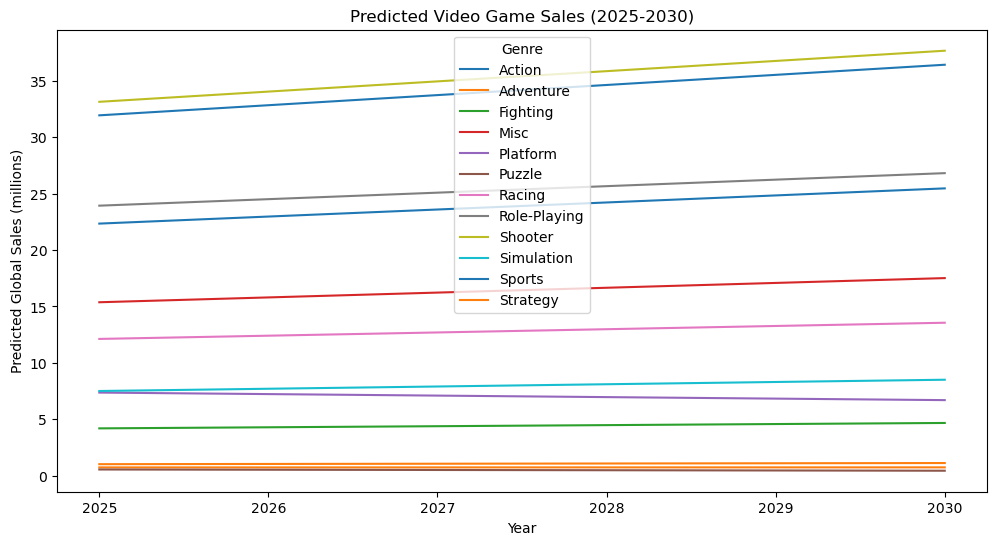

In [207]:
plt.figure(figsize=(12, 6))
for genre in future_df.columns:
    plt.plot(future_df.index, future_df[genre], label=genre)

plt.title("Predicted Video Game Sales (2025-2030)")
plt.xlabel("Year")
plt.ylabel("Predicted Global Sales (millions)")
plt.legend(title="Genre")
plt.show()

# Summary and Conclusion:

In this project, we analyzed video game sales data and built predictive models to forecast future sales by genre. Here are our key findings:

1. **Data Analysis**: We successfully processed and visualized the video game sales data, identifying trends across different genres over time using stem plots as recommended. We found that the top 4 genres predicted to have the best sales are: Shooting, Action, Role-Playing, and 
2. **Model Comparison**: We implemented two types of models:
    - Linear Regression models for each genre
    - Random Forest as an ensemble method
    
    The Random Forest models generally showed lower Mean Absolute Error compared to Linear Regression, suggesting better predictive performance.
 
 3. **Training Period Impact**: Following the professor's suggestion, we tested how reducing the training data (training until 2013 instead of 2014) affected prediction accuracy. As expected, the error increased when using less historical data, confirming that model reliability decreases when predicting further into the future.
 
 4. **Future Predictions**: Our models predict varying trends for different genres from 2025-2030:
    - Some genres show continued growth (such as Action and Shooter)
    - Others show decline or stabilization
 
 5. **Limitations**: Our predictions are based only on historical year and genre trends, without considering other factors like:
    - Technological advancements
    - Industry disruptions
    - Economic factors
    - Changes in gaming platforms and distribution methods
 
 6. **Future Work**: To improve prediction accuracy, future work could:
    - Incorporate additional features (platforms, publishers, user ratings)
    - Use more sophisticated time series models
    - Update the dataset with more recent data (post-2016)
 
Overall, this project demonstrates how machine learning can be applied to predict trends in the video game industry, providing valuable insights for game developers, publishers, and investors.